In [1]:
import pickle
import math
import numpy as np
import pandas as pd
from random import randrange

import urllib.parse
from sqlalchemy import create_engine
import psycopg2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay)

import matplotlib.pyplot as plt
import seaborn as sns

# Disable deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import sys, os
# Add location of config.py in grandparent folder to sys.path
sys.path.append(os.path.abspath(os.path.join('../..')))
from config import db_password

In [2]:
# Set dark theme for matplotlib
plt.style.use('dark_background')

### Load Data from Provisional Database

In [3]:
# Store SQL connection string
db_string = f"postgresql://user:{urllib.parse.quote(db_password)}\
@127.0.0.1:5432/disease_prediction"

# # Connect to SQL database
# # Use 'with' to let Python's context manager call Connection.close()
# with create_engine(db_string).connect() as engine:
#     # Load table from database into DataFrame
#     data_df = pd.read_sql('dataset_clean', engine)

In [34]:
# Load data locally for testing
data_df = pd.read_csv('./Data/Cleaned/dataset_clean.csv')

data_df.iloc[0:5, 0:6]

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
0,fungal infection,itching,skin rash,nodal skin eruptions,mottling skin,NaN
1,fungal infection,skin rash,nodal skin eruptions,mottling skin,NaN,NaN
2,fungal infection,itching,nodal skin eruptions,mottling skin,NaN,NaN
3,fungal infection,itching,skin rash,mottling skin,NaN,NaN
4,fungal infection,itching,skin rash,nodal skin eruptions,NaN,NaN


### Transform DataFrame to Boolean per Symptom

In [5]:
# List of symptom column names from data_df
symptom_cols = data_df.columns.to_list()[1:]

# Get values from symptom columns as an array
symptom_values = data_df[symptom_cols].values.astype(str)

# Get list of unique values from array
symptom_list = list(np.unique(symptom_values))
symptom_list.remove('nan')

In [33]:
# Create boolean DataFrame
bool_df = data_df.reindex(columns=['Disease'] + symptom_list)

# Apply boolean values to bool_df according to presence in data_df row
for col in bool_df[symptom_list]:
    bool_df[col] = [True if np.isin(row, col).any() else False
                    for row in data_df[symptom_cols].to_numpy()]

# Check that no NaN's remain
print(bool_df.isnull().any().any())

bool_df.iloc[0:5, 0:6]

False


,Disease,abdominal pain,abnormal menstruation,acidity,acute liver failure,altered mental state
0,fungal infection,False,False,False,False,False
1,fungal infection,False,False,False,False,False
2,fungal infection,False,False,False,False,False
3,fungal infection,False,False,False,False,False
4,fungal infection,False,False,False,False,False


In [7]:
# Save boolean DataFrame
bool_df.to_csv('./Data/Cleaned/dataset_bool.csv')

### Split Data into Training and Testing

In [8]:
# Split into features and target arrays
y = bool_df['Disease'].values
X = bool_df.drop(columns=['Disease']).values

In [9]:
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
	X, y,
	test_size=0.5,		# better for small samples
	random_state=2718281828		# math constant e
)

### Compile Machine Learning Model

#### Decision Tree Classifier

In [10]:
dtc = DecisionTreeClassifier(criterion='entropy',
    max_depth=10,
    random_state=2718281828    
)
dtc.fit(X_train, y_train)
dtc_predict = dtc.predict(X_test)

# Calculate accuracy score
accuracy_score(y_test, dtc_predict)

0.9479674796747968

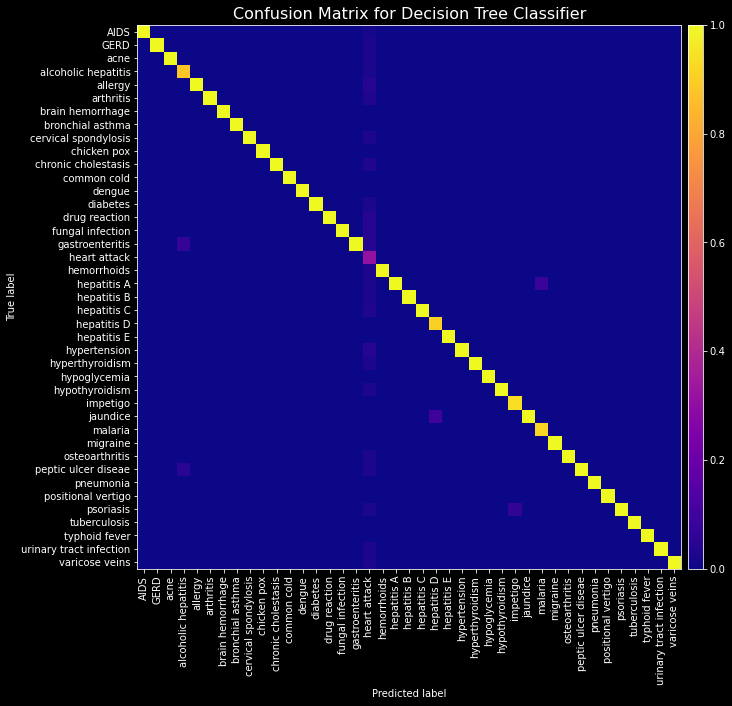

In [22]:
# Generate confusion matrix DTC
dtc_cm = confusion_matrix(y_test, dtc_predict)

# Plot using matplotlib
dtc_fig, dtc_ax = plt.subplots(figsize=(10,10))
dtc_ax.set_title('Confusion Matrix for Decision Tree Classifier',
    fontdict={'fontsize': 16}
)

dtc_display = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=dtc_predict,
    normalize='pred',
    include_values=False,
    xticks_rotation='vertical',
    cmap='plasma',
    ax=dtc_ax,
    colorbar=False
)

# Add custom colorbar
dtc_cax = dtc_fig.add_axes(
    [dtc_ax.get_position().x1 + 0.01,
    dtc_ax.get_position().y0,
    0.02,
    dtc_ax.get_position().height]
)
dtc_cbar = plt.colorbar(dtc_display.im_, cax=dtc_cax)

plt.savefig('./Images/clf_confusion_matrix.png')

In [12]:
# Show sorted feature importances
dtc_imp = sorted(zip(dtc.feature_importances_, bool_df[symptom_list].columns), reverse=True)
dtc_imp

[(0.1641147608827437, 'fatigue'),
 (0.09891399326670915, 'vomiting'),
 (0.0781596601711669, 'loss of appetite'),
 (0.0615983456373097, 'high fever'),
 (0.055429463446322144, 'skin rash'),
 (0.04010081647371965, 'nausea'),
 (0.038874898268178706, 'chest pain'),
 (0.03415728639369311, 'headache'),
 (0.03415405625698062, 'abdominal pain'),
 (0.030665270592667437, 'malaise'),
 (0.028553928559863745, 'neck pain'),
 (0.023509446366634764, 'itching'),
 (0.02347105833496309, 'irritability'),
 (0.017685933201177086, 'muscle pain'),
 (0.016848622208721468, 'yellowing of eyes'),
 (0.016514597698057687, 'stiff neck'),
 (0.015912734410899545, 'joint pain'),
 (0.014752552767459008, 'pain in anal region'),
 (0.012944996257377335, 'slurred speech'),
 (0.012568196336462327, 'bladder discomfort'),
 (0.011759169461493168, 'coma'),
 (0.01141698134830735, 'chills'),
 (0.010074249721739401, 'yellowish skin'),
 (0.00993950804085968, 'excessive urination'),
 (0.00988458743294842, 'diarrhea'),
 (0.009856769144

In [13]:
# Save trained model to Pickle file
pickle.dump(dtc, open('./Models/dtc_model.pkl', 'wb'))

#### Support Vector Machine

In [14]:
# Support Vector Classification
svm = SVC(
    kernel='rbf',	# preferred for nonlinear, unknown data
    gamma=0.2,
    C=0.021,
    random_state=2718281828
)
svm.fit(X_train, y_train)
svm_predict = svm.predict(X_test)

# Calculate accuracy score
accuracy_score(y_test, svm_predict)

0.9841463414634146

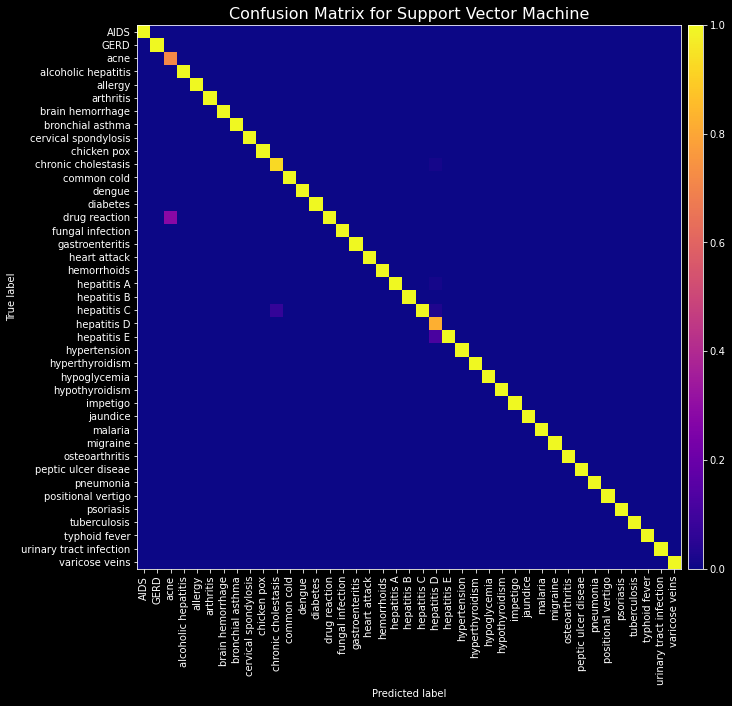

In [15]:
# Generate confusion matrix SVM
svm_cm = confusion_matrix(y_test, svm_predict)

svm_fig, svm_ax = plt.subplots(figsize=(10,10))
svm_ax.set_title('Confusion Matrix for Support Vector Machine',
    fontdict={'fontsize': 16}
)

svm_display = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=svm_predict,
    normalize='pred',
    include_values=False,
    xticks_rotation='vertical',
    cmap='plasma',
    ax=svm_ax,
    colorbar=False
)

# Add custom colorbar
svm_cax = svm_fig.add_axes(
    [svm_ax.get_position().x1 + 0.01,
    svm_ax.get_position().y0,
    0.02,
    svm_ax.get_position().height]
)
plt.colorbar(svm_display.im_, cax=svm_cax)

plt.savefig('./Images/svm_confusion_matrix.png')

In [16]:
# Save trained model to Pickle file
pickle.dump(svm, open('./Models/svm_model.pkl', 'wb'))

In [17]:
# Check model predictions for a random test case
test_seed = randrange(0, len(X_test))
test_case = X_test[test_seed]

print("Actual: " + y_test[test_seed] + "\n")
print("Model Predictions:")

for x in [dtc, svm]:
    print(f"{x.__class__.__name__}: " +
        x.predict(test_case.reshape(1, -1))[0]
    )

Actual: acne

Model Predictions:
DecisionTreeClassifier: acne
SVC: acne
